## Quarterfinals

In [224]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
warnings.filterwarnings('ignore')
%matplotlib inline

Load data

In [225]:
# Load all football match data since 1872
data = pd.read_csv('international_matches.csv')
data.head()

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,...,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
0,1993-08-08,Bolivia,Uruguay,South America,South America,59,22,0,0,3,...,No,Win,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1993-08-08,Brazil,Mexico,South America,North America,8,14,0,0,1,...,No,Draw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1993-08-08,Ecuador,Venezuela,South America,South America,35,94,0,0,5,...,No,Win,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1993-08-08,Guinea,Sierra Leone,Africa,Africa,65,86,0,0,1,...,No,Win,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1993-08-08,Paraguay,Argentina,South America,South America,67,5,0,0,1,...,No,Lose,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [226]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23921 entries, 0 to 23920
Data columns (total 25 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   date                           23921 non-null  object 
 1   home_team                      23921 non-null  object 
 2   away_team                      23921 non-null  object 
 3   home_team_continent            23921 non-null  object 
 4   away_team_continent            23921 non-null  object 
 5   home_team_fifa_rank            23921 non-null  int64  
 6   away_team_fifa_rank            23921 non-null  int64  
 7   home_team_total_fifa_points    23921 non-null  int64  
 8   away_team_total_fifa_points    23921 non-null  int64  
 9   home_team_score                23921 non-null  int64  
 10  away_team_score                23921 non-null  int64  
 11  tournament                     23921 non-null  object 
 12  city                           23921 non-null 

In [227]:
# Format date
data['date'] = pd.to_datetime(data['date'])

In [228]:
data.columns

Index(['date', 'home_team', 'away_team', 'home_team_continent',
       'away_team_continent', 'home_team_fifa_rank', 'away_team_fifa_rank',
       'home_team_total_fifa_points', 'away_team_total_fifa_points',
       'home_team_score', 'away_team_score', 'tournament', 'city', 'country',
       'neutral_location', 'shoot_out', 'home_team_result',
       'home_team_goalkeeper_score', 'away_team_goalkeeper_score',
       'home_team_mean_defense_score', 'home_team_mean_offense_score',
       'home_team_mean_midfield_score', 'away_team_mean_defense_score',
       'away_team_mean_offense_score', 'away_team_mean_midfield_score'],
      dtype='object')

In [229]:
# Keep only relevent columns
data = data.drop(['home_team_continent',
       'away_team_continent','tournament', 'city', 'country',
       'neutral_location'], axis = 1)

In [230]:
fifa_rank = data[['date', 'home_team', 'away_team', 'home_team_fifa_rank', 'away_team_fifa_rank', 'away_team_total_fifa_points', 'home_team_total_fifa_points',
        ]]
home = data[['date', 'home_team', 'home_team_fifa_rank', 'home_team_total_fifa_points']].rename(columns={'home_team': 'team', 'home_team_fifa_rank': 'rank','home_team_total_fifa_points': 'rank_points'})
away = data[['date', 'away_team', 'away_team_fifa_rank', 'away_team_total_fifa_points']].rename(columns={'away_team': 'team', 'away_team_fifa_rank': 'rank', 
                                                                                                          'away_team_total_fifa_points':'rank_points'})
fifa_rank = home.append(away)
fifa_rank = fifa_rank.sort_values(['team', 'date'], ascending = [True, False])
fifa_rank['row_number'] = fifa_rank.groupby('team').cumcount()+1
# Look at 10 top teams
fifa_rank_top = fifa_rank[fifa_rank['row_number']==1].drop('row_number', axis = 1).nsmallest(10, 'rank')

In [231]:
fifa_rank_top

,date,team,rank,rank_points
23760,2022-06-06,Brazil,1,1832
23909,2022-06-14,Belgium,2,1827
23885,2022-06-13,France,3,1789
23741,2022-06-05,Argentina,4,1765
23906,2022-06-14,England,5,1761
23907,2022-06-14,Italy,6,1723
23866,2022-06-12,Spain,7,1709
23867,2022-06-12,Portugal,8,1674
23903,2022-06-14,Mexico,9,1658
23908,2022-06-14,Netherlands,10,1658


In [232]:
# Find columns with null values
col_with_nulls = [col for col in data.columns if data[col].isnull().any()]
for col in col_with_nulls:
    print(col)

home_team_goalkeeper_score
away_team_goalkeeper_score
home_team_mean_defense_score
home_team_mean_offense_score
home_team_mean_midfield_score
away_team_mean_defense_score
away_team_mean_offense_score
away_team_mean_midfield_score


In [233]:
# Teams in quarterfinals
quarters_teams = ['Brazil', 'Croatia', 'Arentina', 'Netherlands', 'England', 'France', 'Morocco', 'Portugal']

In [234]:
# Fill null values with mean
for i in quarters_teams:
    for j in col_with_nulls:
        data[j].fillna(data[data[j[0:9]]==i][j].mean(), inplace = True)

In [235]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23921 entries, 0 to 23920
Data columns (total 19 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   date                           23921 non-null  datetime64[ns]
 1   home_team                      23921 non-null  object        
 2   away_team                      23921 non-null  object        
 3   home_team_fifa_rank            23921 non-null  int64         
 4   away_team_fifa_rank            23921 non-null  int64         
 5   home_team_total_fifa_points    23921 non-null  int64         
 6   away_team_total_fifa_points    23921 non-null  int64         
 7   home_team_score                23921 non-null  int64         
 8   away_team_score                23921 non-null  int64         
 9   shoot_out                      23921 non-null  object        
 10  home_team_result               23921 non-null  object        
 11  home_team_goalk

In [236]:
# Only look at recent games
recent = '2021-01-01'
cur_data = data[data['date']>recent]
# Remove date column
data.drop(['date'], axis = 1)
cur_data.head(

SyntaxError: unexpected EOF while parsing (1655610952.py, line 6)

In [237]:
# Find data relating to remaining teams
quarters_data = cur_data[cur_data['home_team'].isin(quarters_teams)]
quarters_data.head()

,date,home_team,away_team,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,away_team_score,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
22298,2021-03-24,Portugal,Azerbaijan,5,108,1662,1180,1,0,No,Win,84.0,86.490909,83.8,84.3,85.2,86.086364,86.700909,61.200000
22300,2021-03-24,France,Ukraine,2,24,1755,1521,1,1,No,Draw,87.0,76.000000,85.5,86.7,87.0,76.000000,77.000000,79.800000
22335,2021-03-25,England,San Marino,4,210,1670,810,5,0,No,Win,82.0,86.490909,84.5,87.7,83.8,86.086364,86.700909,85.465455
22373,2021-03-27,Netherlands,Latvia,14,136,1609,1082,2,0,No,Win,81.0,70.000000,85.2,82.3,84.0,86.086364,86.700909,85.465455
22376,2021-03-27,Croatia,Cyprus,11,100,1617,1224,1,0,No,Win,80.0,86.490909,78.8,78.7,84.0,86.086364,86.700909,60.000000


In [238]:
# Drop games that tied
binary_data = cur_data[cur_data['home_team_result'].isin(['Win', 'Lose'])]
binary_data.head()

,date,home_team,away_team,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,away_team_score,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
22274,2021-01-18,Kuwait,Palestine,148,102,1060,1204,0,1,No,Lose,86.074074,86.490909,85.785185,86.392593,85.244444,86.086364,86.700909,85.465455
22275,2021-01-19,Dominican Republic,Puerto Rico,159,179,1019,941,0,1,No,Lose,86.074074,86.490909,85.785185,86.392593,85.244444,86.086364,86.700909,85.465455
22276,2021-01-22,Guatemala,Puerto Rico,131,179,1111,941,1,0,No,Win,86.074074,86.490909,85.785185,86.392593,85.244444,86.086364,86.700909,85.465455
22278,2021-01-27,Iraq,Kuwait,69,148,1347,1060,2,1,No,Win,86.074074,86.490909,85.785185,86.392593,85.244444,86.086364,86.700909,85.465455
22280,2021-01-31,USA,Trinidad and Tobago,22,103,1545,1201,7,0,No,Win,76.000000,52.000000,75.500000,76.700000,75.200000,86.086364,86.700909,85.465455


In [239]:
# Create win column
def encode_win(x):
    if x == 'Win':
        return 1
    elif x == 'Draw':
        return -1
    else:
        return 0
win_col = binary_data['home_team_result'].transform(encode_win)
win_col

22274    0
22275    0
22276    1
22278    1
22280    1
        ..
23916    1
23917    0
23918    0
23919    0
23920    1
Name: home_team_result, Length: 1296, dtype: int64

In [240]:
binary_data['result'] = win_col

In [241]:
binary_data = binary_data.drop('home_team_result', axis=1)
binary_data.head()

,date,home_team,away_team,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,away_team_score,shoot_out,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score,result
22274,2021-01-18,Kuwait,Palestine,148,102,1060,1204,0,1,No,86.074074,86.490909,85.785185,86.392593,85.244444,86.086364,86.700909,85.465455,0
22275,2021-01-19,Dominican Republic,Puerto Rico,159,179,1019,941,0,1,No,86.074074,86.490909,85.785185,86.392593,85.244444,86.086364,86.700909,85.465455,0
22276,2021-01-22,Guatemala,Puerto Rico,131,179,1111,941,1,0,No,86.074074,86.490909,85.785185,86.392593,85.244444,86.086364,86.700909,85.465455,1
22278,2021-01-27,Iraq,Kuwait,69,148,1347,1060,2,1,No,86.074074,86.490909,85.785185,86.392593,85.244444,86.086364,86.700909,85.465455,1
22280,2021-01-31,USA,Trinidad and Tobago,22,103,1545,1201,7,0,No,76.000000,52.000000,75.500000,76.700000,75.200000,86.086364,86.700909,85.465455,1


In [242]:
binary_data = binary_data.drop('shoot_out', axis=1)
binary_data = binary_data.drop('home_team_score', axis=1)
binary_data = binary_data.drop('away_team_score', axis=1)
binary_data.head()

,date,home_team,away_team,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score,result
22274,2021-01-18,Kuwait,Palestine,148,102,1060,1204,86.074074,86.490909,85.785185,86.392593,85.244444,86.086364,86.700909,85.465455,0
22275,2021-01-19,Dominican Republic,Puerto Rico,159,179,1019,941,86.074074,86.490909,85.785185,86.392593,85.244444,86.086364,86.700909,85.465455,0
22276,2021-01-22,Guatemala,Puerto Rico,131,179,1111,941,86.074074,86.490909,85.785185,86.392593,85.244444,86.086364,86.700909,85.465455,1
22278,2021-01-27,Iraq,Kuwait,69,148,1347,1060,86.074074,86.490909,85.785185,86.392593,85.244444,86.086364,86.700909,85.465455,1
22280,2021-01-31,USA,Trinidad and Tobago,22,103,1545,1201,76.000000,52.000000,75.500000,76.700000,75.200000,86.086364,86.700909,85.465455,1


In [243]:
# Split into x, y
x = binary_data.drop('result', axis=1)
x = x.drop('home_team', axis=1)
x = x.drop('away_team', axis=1)
x = x.drop('date', axis=1)
y = binary_data['result']

In [244]:
x.head()
feature_names = x.columns

In [245]:
y.head()

22274    0
22275    0
22276    1
22278    1
22280    1
Name: result, dtype: int64

In [246]:
# Split into training, testing data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=12)

Apply random forest algorithm

In [247]:
rf = RandomForestRegressor(n_estimators=100)
rf.fit(x_train, y_train)

RandomForestRegressor()

In [248]:
# Get feature importances
rf.feature_importances_

array([0.17726493, 0.13487846, 0.14864802, 0.20433616, 0.03984182,
       0.03340787, 0.02867067, 0.05743989, 0.03206534, 0.04013051,
       0.04043445, 0.06288187])

<BarContainer object of 12 artists>

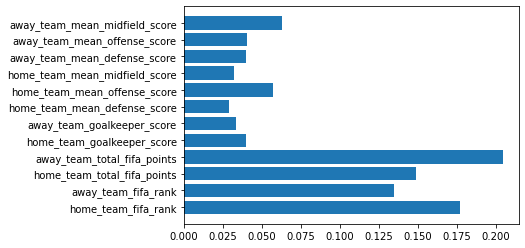

In [249]:
# Plot feature importances 
plt.barh(feature_names, rf.feature_importances_)

Apply logistic regression model

In [250]:
lr_model = LogisticRegression(random_state=16)
# Fit the LR model
lr_model.fit(x_train, y_train)

LogisticRegression(random_state=16)

In [251]:
# Get predictions for test set
y_pred = lr_model.predict(x_test)

In [252]:
# Determine accuracy
accuracy_score(y_test, y_pred)

0.7808641975308642

### Apply model to quarterfinals matchups

In [253]:
# Get most recent data for quarter finals teams
quarters_data.sort_values(by='date', ascending=False)

,date,home_team,away_team,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,away_team_score,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
23908,2022-06-14,Netherlands,Wales,10,18,1658,1588,3,2,No,Win,81.0,74.000000,85.2,83.0,83.5,75.000000,73.000000,78.500000
23906,2022-06-14,England,Hungary,5,40,1761,1466,0,4,No,Lose,83.0,85.000000,85.0,88.0,84.0,75.500000,72.700000,73.000000
23885,2022-06-13,France,Croatia,3,16,1789,1621,0,1,No,Lose,87.0,82.000000,84.2,88.3,86.8,77.800000,76.700000,84.200000
23879,2022-06-13,Morocco,Liberia,24,149,1551,1050,2,0,No,Win,82.0,86.490909,81.2,81.7,76.2,86.086364,64.000000,85.465455
23854,2022-06-11,Netherlands,Poland,10,26,1658,1544,2,2,No,Draw,81.0,87.000000,85.2,83.0,83.5,75.200000,84.700000,75.800000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22376,2021-03-27,Croatia,Cyprus,11,100,1617,1224,1,0,No,Win,80.0,86.490909,78.8,78.7,84.0,86.086364,86.700909,60.000000
22373,2021-03-27,Netherlands,Latvia,14,136,1609,1082,2,0,No,Win,81.0,70.000000,85.2,82.3,84.0,86.086364,86.700909,85.465455
22335,2021-03-25,England,San Marino,4,210,1670,810,5,0,No,Win,82.0,86.490909,84.5,87.7,83.8,86.086364,86.700909,85.465455
22300,2021-03-24,France,Ukraine,2,24,1755,1521,1,1,No,Draw,87.0,76.000000,85.5,86.7,87.0,76.000000,77.000000,79.800000


In [254]:
# Get most recent data for each team
def get_team_stats(team, d):
    l = []
    for index, row in d.iterrows():
        if row['home_team'] == team:
            l = [row['home_team_fifa_rank'],row['home_team_total_fifa_points'], row['home_team_goalkeeper_score'],
                 row['home_team_mean_defense_score'],row['home_team_mean_offense_score'],row['home_team_mean_midfield_score']]
            return l
        if row['away_team'] == team:
            l = [row['away_team_fifa_rank'],row['away_team_total_fifa_points'], row['away_team_goalkeeper_score'],
                 row['away_team_mean_defense_score'],row['away_team_mean_offense_score'],row['away_team_mean_midfield_score']]
            return l            

In [255]:
# Set most recent data
por_stats = get_team_stats('Portugal', quarters_data.sort_values(by='date', ascending=False))
arg_stats = get_team_stats('Argentina', quarters_data.sort_values(by='date', ascending=False))
bra_stats = get_team_stats('Brazil', quarters_data.sort_values(by='date', ascending=False))
cro_stats = get_team_stats('Croatia', quarters_data.sort_values(by='date', ascending=False))
ned_stats = get_team_stats('Netherlands', quarters_data.sort_values(by='date', ascending=False))
mor_stats = get_team_stats('Morocco', quarters_data.sort_values(by='date', ascending=False))
fra_stats = get_team_stats('France', quarters_data.sort_values(by='date', ascending=False))
eng_stats = get_team_stats('England', quarters_data.sort_values(by='date', ascending=False))

In [256]:
# Create matchups
def matchup(home_stats, away_stats):
    l = []
    i = 0
    while i<6:
        l.append(home_stats[i])
        l.append(away_stats[i])
        i+=1
    return l

In [279]:
# Brazil - Croatia
bra_cro = pd.DataFrame([matchup(bra_stats, cro_stats)])
# Argentina - Netherlands
arg_ned = pd.DataFrame([matchup(arg_stats, ned_stats)])
# Portugal - Morocco
por_mor = pd.DataFrame([matchup(por_stats, mor_stats)])
# France - Englad
fra_eng = pd.DataFrame([matchup(fra_stats, eng_stats)])

Run predictions

In [277]:
# Displaying out put model
def find_winner(home, away, stats):
    if lr_model.predict(bra_cro) > 0:
        print(home)
    else:
        print(away)

In [282]:
# Brazil - Croatia
find_winner('Brazil', 'Croatia', bra_cro)
# Argentina - Netherlands
find_winner('Argentina', 'Netherlands', arg_ned)
# Portugal - Morocco
find_winner('Portugal', 'Morocco', por_mor)
# France - Englad
find_winner('France', 'England', fra_eng)

Brazil
Argentina
Portugal
France


### Apply to semifinals matchups

In [283]:
# Get stats
# Argentina - Croatia
arg_cro = pd.DataFrame([matchup(arg_stats, cro_stats)])
# France - Morocco
fra_mor = pd.DataFrame([matchup(fra_stats, mor_stats)])

In [284]:
# Argentina - Croatia
find_winner('Argentina', 'Croatia', arg_cro)
# France - Morocco
find_winner('France', 'Morocco', fra_mor)

Argentina
France


## Apply to finals

In [286]:
# France - Argentina
fra_arg = pd.DataFrame([matchup(fra_stats, arg_stats)])
find_winner('France', 'Argentina', fra_arg)

France
